In [552]:
#Calculates the number of Clenches in individual .csv file of EEG data caused by fluctuations in Electric Potential.

In [553]:
from scipy import fft, arange, signal
from scipy.special import logit, expit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import csv
import pandas as pd
from ttictoc import TicToc
#----------------------
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
#---------------------RF HP-f(x) & CV---------------
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

In [554]:
EEG_FOLDER = "../../data/Clench/Official_Tests"

In [555]:
def read_file(path):
    """
    Reads the audio .wav file and returns the sample rate and data contents of the file.
    """
    sr, signal = wavfile.read(path)
    return sr, signal[:,0]

In [556]:
def read_all(files):
    """Branch audio file extrapolation. Uses read_file() method."""
    ret = []
    t = TicToc()
    t.tic();
    for fl in files:
        ret.append(read_file(fl))
    t.toc();
    print("Time it took to read data from files of length ", len(files), " = ", round(t.elapsed, 3), " seconds.")
    return np.array(ret)

In [557]:
def find_files(PATH, ext):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if ext in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [558]:
files = find_files(EEG_FOLDER, ".csv")

In [559]:
files

['../../data/Clench/Official_Tests/1_test.csv',
 '../../data/Clench/Official_Tests/2_test.csv',
 '../../data/Clench/Official_Tests/3_test.csv']

In [560]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        dtx = rows[0].split(",")[3:8]
        cont = []
        for x in dtx:
            cont.append(float(x))
        row_data.append(cont)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [561]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return raw_data, dataframes

In [562]:
bci_data, bci_df = data_DF_dir(files)

In [563]:
files

['../../data/Clench/Official_Tests/1_test.csv',
 '../../data/Clench/Official_Tests/2_test.csv',
 '../../data/Clench/Official_Tests/3_test.csv']

In [564]:
friendly_name = [x.split("/")[-1].split("_")[0] for x in files]

In [565]:
def count_peaks_validation(peaks, x, threshold_vertical):
    count = 0
    for states in peaks:
        if(states > threshold_vertical):
            count += 1
    plt.plot(x)
    plt.xlabel("Time (sample_rate (128) per second expansion)")
    plt.ylabel("Amplitude")
    plt.title("Time Domain Chart of Peak count (One-Sided f(x))", y=1.08)
    return count

In [566]:
def ease(index, distance, start_index, threshold_vertical, height, width):
    dataCV = []
    for i in range(0, 5):
        x = bci_data[index].T[i][start_index:]
        x = abs(x - np.average(x))  # biasing.
        peaks, props = signal.find_peaks(x, distance=distance, height=height, width=width)
        count = count_peaks_validation(peaks, x, threshold_vertical)
        dataCV.append(count)
    count = round(np.array(dataCV).mean())
    return int(friendly_name[index]), count

In [567]:
def decode_brain_wave():
    count = []
    for i in range(len(friendly_name)):
        p,t = ease(i, 249, 309, 50, 200, 1)
        count.append(t)
    opA = ''
    opB = ''
    operation = ['+','-','*','/']
    result = 0

    check = False
    for x in count:
        x = int(x)
        if(x < 10):
            if(check == True):
                opB += str(x)
            else:
                opA += str(x)
        else:
            operation = operation[int(x%10)]
            check = True
    opA = int(opA)
    opB = int(opB)

    result = opA / opB
    if(operation == '+'):
        result = opA + opB
    elif(operation == '-'):
        result = opA - opB
    elif(operation == '*'):
        result = opA * opB

    print(opA, operation, opB, " = ", result)

2 * 8  =  16


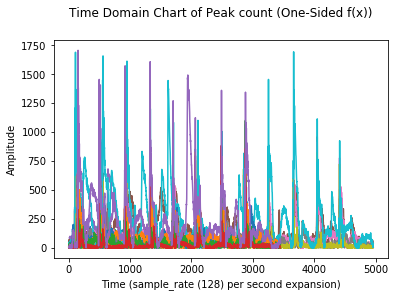

In [568]:
decode_brain_wave()

In [87]:
def validation(distance, start_index, threshold_vertical, cv_width, CV=False):
    
    validation_score = 0
    samples_correct = []
    samples_wrong = []
    
    for index in range(len(friendly_name)):
        test, pred = ease(index, distance, start_index, threshold_vertical, cv_width)
        if(test == pred):
            validation_score += 1
            samples_correct.append(friendly_name[index])
        else:
            samples_wrong.append([friendly_name[index], pred])
    
    if(CV == False):
        print("Final Result :\n\nSamples Correct: ", str(validation_score), "\nSamples Incorrect : ", str(len(samples_wrong)), "\n")
        if(len(samples_wrong) > 0):
            for wr in range(len(samples_wrong)):
                print("Incorrect Sample #", str(wr+1), ": ", str(samples_wrong[wr][0]), "\tPredicted : ", str(samples_wrong[wr][1]))
    return validation_score, samples_correct, samples_wrong

In [45]:
high = []
start_index = 0
for sid in range(250, 260):
    highest = 0
    high_index = 0
    count_first_off = False
    fluc_point = 0
    threshold_vertical = 0
    print("\n\n")
    for cv in range(250, 400):
        control = cv
        for t_iv in range(500, 510):
            sc,_,_ = validation(control, sid, t_iv, True)
            if(sc > highest):
                highest = sc
                high_index = control
                start_index = sid
                if(highest >= 11):
                    print("Highest score recorded at :", highest, "\t Index [distance] at : ", control, "\tStart Index :", sid)
            elif(sc < highest and highest >= 11 and count_first_off == False):
                print("Fluctuation from Highest Point at : ", control, "\tScore : ", sc)
                count_first_off = True
                fluc_point = control
            
    high.append((highest, high_index, fluc_point, sid, t_iv))




Highest score recorded at : 12 	 Index [distance] at :  250 	Start Index : 250
Fluctuation from Highest Point at :  255 	Score :  11


KeyboardInterrupt: 

In [16]:
high

[(12, 249, 255, 250),
 (12, 249, 255, 251),
 (12, 249, 255, 252),
 (12, 249, 255, 253),
 (12, 249, 255, 254),
 (12, 223, 225, 255),
 (12, 223, 225, 256),
 (12, 223, 225, 257),
 (12, 223, 225, 258),
 (13, 249, 250, 259)]

## Start Point:
>Highest score recorded at : 11 	 Index [distance] at :  215 	Start Index : 259
>
>Highest score recorded at : 12 	 Index [distance] at :  223 	Start Index : 259
>
>Highest score recorded at : 13 	 Index [distance] at :  249 	Start Index : 259
>
>Fluctuation from Highest Point at :  250 	Score :  12
>
>DATA : (13, 249, 250, 259)

## End Point:

> Highest score recorded at : 11 	 Index !distance at :  213 	Start Index : 359
> 
> Highest score recorded at : 12 	 Index !distance at :  214 	Start Index : 359
>
> Highest score recorded at : 13 	 Index !distance at :  249 	Start Index : 359
>
> Fluctuation from Highest Point at :  255 	Score :  12
>
> DATA : (13, 249, 255, 359)

### Therefore, Average :
> horizontal_distance : 259
>
> start_index : 309

### Validation

In [103]:
for x in range(0, 40):
    for y in range(0, 10):
        control = x + 0.1*y
        v,c,w = validation(249, 309, 450, control, True)
        if(v < 13):
            print(v, "<<<<< VALUE >>>>>", control, "<<<< INDEX")
    

12 <<<<< VALUE >>>>> 0.6000000000000001 <<<< INDEX
12 <<<<< VALUE >>>>> 0.7000000000000001 <<<< INDEX
12 <<<<< VALUE >>>>> 0.8 <<<< INDEX
12 <<<<< VALUE >>>>> 0.9 <<<< INDEX
12 <<<<< VALUE >>>>> 1.0 <<<< INDEX
12 <<<<< VALUE >>>>> 1.1 <<<< INDEX
12 <<<<< VALUE >>>>> 1.2 <<<< INDEX
12 <<<<< VALUE >>>>> 1.3 <<<< INDEX
12 <<<<< VALUE >>>>> 1.4 <<<< INDEX
12 <<<<< VALUE >>>>> 1.5 <<<< INDEX
12 <<<<< VALUE >>>>> 1.6 <<<< INDEX
12 <<<<< VALUE >>>>> 1.7000000000000002 <<<< INDEX
12 <<<<< VALUE >>>>> 1.8 <<<< INDEX
12 <<<<< VALUE >>>>> 1.9 <<<< INDEX
12 <<<<< VALUE >>>>> 2.0 <<<< INDEX
12 <<<<< VALUE >>>>> 2.1 <<<< INDEX
12 <<<<< VALUE >>>>> 2.2 <<<< INDEX
12 <<<<< VALUE >>>>> 2.3 <<<< INDEX
12 <<<<< VALUE >>>>> 2.4 <<<< INDEX
12 <<<<< VALUE >>>>> 2.5 <<<< INDEX
12 <<<<< VALUE >>>>> 2.6 <<<< INDEX
12 <<<<< VALUE >>>>> 2.7 <<<< INDEX
12 <<<<< VALUE >>>>> 2.8 <<<< INDEX
12 <<<<< VALUE >>>>> 2.9 <<<< INDEX
12 <<<<< VALUE >>>>> 3.0 <<<< INDEX
12 <<<<< VALUE >>>>> 3.1 <<<< INDEX
12 <<<<< VALUE >>>>

11 <<<<< VALUE >>>>> 24.8 <<<< INDEX
11 <<<<< VALUE >>>>> 24.9 <<<< INDEX
11 <<<<< VALUE >>>>> 25.0 <<<< INDEX
11 <<<<< VALUE >>>>> 25.1 <<<< INDEX
11 <<<<< VALUE >>>>> 25.2 <<<< INDEX
11 <<<<< VALUE >>>>> 25.3 <<<< INDEX
11 <<<<< VALUE >>>>> 25.4 <<<< INDEX
11 <<<<< VALUE >>>>> 25.5 <<<< INDEX
11 <<<<< VALUE >>>>> 25.6 <<<< INDEX
11 <<<<< VALUE >>>>> 25.7 <<<< INDEX
11 <<<<< VALUE >>>>> 25.8 <<<< INDEX
11 <<<<< VALUE >>>>> 25.9 <<<< INDEX
11 <<<<< VALUE >>>>> 26.0 <<<< INDEX
11 <<<<< VALUE >>>>> 26.1 <<<< INDEX
12 <<<<< VALUE >>>>> 26.2 <<<< INDEX
12 <<<<< VALUE >>>>> 26.3 <<<< INDEX
12 <<<<< VALUE >>>>> 26.4 <<<< INDEX
12 <<<<< VALUE >>>>> 26.5 <<<< INDEX
12 <<<<< VALUE >>>>> 26.6 <<<< INDEX
12 <<<<< VALUE >>>>> 26.7 <<<< INDEX
12 <<<<< VALUE >>>>> 26.8 <<<< INDEX
12 <<<<< VALUE >>>>> 26.9 <<<< INDEX
12 <<<<< VALUE >>>>> 27.0 <<<< INDEX
12 <<<<< VALUE >>>>> 27.1 <<<< INDEX
12 <<<<< VALUE >>>>> 27.2 <<<< INDEX
12 <<<<< VALUE >>>>> 27.3 <<<< INDEX
12 <<<<< VALUE >>>>> 27.4 <<<< INDEX
1

In [100]:
v,c,w = validation(249, 309, 500, 14)

Final Result :

Samples Correct:  12 
Samples Incorrect :  3 

Incorrect Sample # 1 :  002 	Predicted :  3.0
Incorrect Sample # 2 :  003 	Predicted :  2.0
Incorrect Sample # 3 :  011 	Predicted :  14.0


In [433]:
### Let's Test the following:

# + = 10
# - = 11
# x = 12
# % = 13

# 21 x 34

# 1. 2
# 2. 1

# 3. X <-- 12

# 4. 3 
# 5. 4